```{currentmodule} tskit
```

In [1]:
import msprime
import numpy as np
import tskit

def computing_statistics():
    ts = msprime.simulate(
        10**4, Ne=10**4, recombination_rate=1e-8, mutation_rate=1e-8, length=10**7, random_seed=42)
    ts.dump("data/computing_statistics.trees")
    
def afs():
    ts = msprime.simulate(6, mutation_rate=1, random_seed=47)
    # remove the mutation times so the plot is nicer
    tables = ts.dump_tables()
    tables.mutations.time = np.full_like(tables.mutations.time, tskit.UNKNOWN_TIME)
    ts = tables.tree_sequence()
    ts.dump("data/afs.trees")


def create_notebook_data():
    computing_statistics()
    afs()

# create_notebook_data()  # uncomment to recreate the tree seqs used in this notebook

(sec_analysing_tree_sequences)=

# _Analysing tree sequences_
% remove underscores in title when tutorial is complete or near-complete

:::{note}
This tutorial is a work in progress.
:::


(sec_tutorial_stats)=

## Computing statistics

Tskit provides an extensive and flexible interface for computing population
genetic statistics, which is documented in detail in the
{ref}`general statistics <sec_stats>` section of the offical documentation.
This tutorial aims to give a quick overview of how the APIs work and how to use
them effectively.

First, let's load a tree sequence to work with which has roughly human
parameters for 10 thousand samples and 10Mb chromosomes:

In [2]:
ts = tskit.load("data/computing_statistics.trees")
ts

This tree sequence has ~36.6 thousand trees & ~39 thousand segregating sites.
We'd now like to compute some statistics on this dataset.

### One-way statistics

We refer to statistics that are defined with respect to a single set of
samples as "one-way". An example of such a statistic is diversity, which
is computed using the {meth}`TreeSequence.diversity` method:

In [3]:
d = ts.diversity()
print("Average diversity per unit sequence length = {d:.3G}")

Average diversity per unit sequence length = {d:.3G}


This tells the average diversity across the whole sequence and returns a single
number. We'll usually want to compute statistics in
{ref}`windows <tskit:sec_stats_windows>` along the genome and we
use the ``windows`` argument to do this:

In [4]:
windows = np.linspace(0, ts.sequence_length, num=5)
d = ts.diversity(windows=windows)
print(windows, d, sep="\n")

[       0.  2500000.  5000000.  7500000. 10000000.]
[0.00040717 0.00040891 0.00041644 0.00039899]


The ``windows`` argument takes a numpy array specifying the breakpoints
along the genome. Here, we use numpy to create four equally spaced windows
of size 2.5 megabases (the windows array contains k + 1 elements to define
k windows). Because we have asked for values in windows, tskit now returns
a numpy array rather than a single value. (See
{ref}`sec_stats_output_dimensions` for a full description of how the output
dimensions of statistics are determined by the ``windows`` argument.)

Suppose we wanted to compute diversity within a specific subset of samples.
We can do this using the ``sample_sets`` argument:

In [5]:
A = ts.samples()[:100]
d = ts.diversity(sample_sets=A)
print(d)

0.00041007806060604034


Here, we've computed the average diversity within the first hundred samples across
the whole genome. As we've not specified any windows, this is again a single value.

We can also compute diversity in *multiple* sample sets at the same time by providing
a list of sample sets as an argument:

In [6]:
A = ts.samples()[:100]
B = ts.samples()[100:200]
C = ts.samples()[200:300]
d = ts.diversity(sample_sets=[A, B, C])
print(d)

[0.00041008 0.00040893 0.00040853]


Because we've computed multiple statistics concurrently, tskit returns a numpy array
of these statistics. We have asked for diversity within three different sample sets,
and tskit therefore returns an array with three values. (In general, the
dimensions of the input determines the dimensions of the output: see
{ref}`tskit:sec_stats_output_dimensions` for a detailed description of the rules.)

We can also compute multiple statistics in multiple windows:

In [7]:
d = ts.diversity(sample_sets=[A, B, C], windows=windows)
print("shape = ", d.shape, "\n", d)

shape =  (4, 3) 
 [[0.00041199 0.00040542 0.00040588]
 [0.00040889 0.00041216 0.00041419]
 [0.00041636 0.00041463 0.0004128 ]
 [0.00040307 0.0004035  0.00040126]]


We have computed diversity within three different sample sets across four
genomic windows, and our output is therefore a 2D numpy array with four
rows and three columns: each row contains the diversity values within
A, B and C for a particular window.

### Multi-way statistics

Many population genetic statistics compare multiple sets of samples to
each other. For example, the {meth}`TreeSequence.divergence` method computes
the divergence between two subsets of samples:

In [8]:
A = ts.samples()[:100]
B = ts.samples()[:100]
d = ts.divergence([A, B])
print(d)

0.0004059772800000012


The divergence between two sets of samples A and B is a single number,
and we we again return a single floating point value as the result. We can also
compute this in windows along the genome, as before:

In [9]:
d = ts.divergence([A, B], windows=windows)
print(d)

[0.00040787 0.00040481 0.00041219 0.00039904]


Again, as we have defined four genomic windows along the sequence, the result is
numpy array with four values.

A powerful feature of tskit's stats API is that we can compute the divergences
between multiple sets of samples simultaneously using the ``indexes`` argument:

In [10]:
d = ts.divergence([A, B, C], indexes=[(0, 1), (0, 2)])
print(d)

[0.00040598 0.00040943]


Here, we've specified three sample sets A, B and C and we've computed the
divergences between A and B,  and between A and C. The ``indexes`` argument is used
to specify which pairs of sets we are interested in. In this example
we've computed two different divergence values and the output is therefore
a numpy array of length 2.

As before, we can combine computing multiple statistics in multiple windows
to return a 2D numpy array:

In [11]:
windows = np.linspace(0, ts.sequence_length, num=5)
d = ts.divergence([A, B, C], indexes=[(0, 1), (0, 2)], windows=windows)
print(d)

[[0.00040787 0.00040834]
 [0.00040481 0.00041207]
 [0.00041219 0.00041464]
 [0.00039904 0.00040267]]


Each row again corresponds to a window, which contains the average divergence
values between the chosen sets.

If the ``indexes`` parameter is 1D array, we interpret this as specifying
a single statistic and remove the empty outer dimension:

In [12]:
d = ts.divergence([A, B, C], indexes=(0, 1))
print(d)

0.0004059772800000012


It's important to note that we don't **have** to remove empty dimensions: tskit
will only do this if you explicitly ask it to. Here, for example, we can keep the
output as an array with one value if we wish:

```
d = ts.divergence([A, B, C], indexes=[(0, 1)])
print(d)
```

Please see {ref}`tskit:sec_stats_sample_sets` for a
full description of the ``sample_sets`` and ``indexes`` arguments.

(sec_tutorial_afs)=

## Allele frequency spectra

The allele frequency spectrum is a fundamental tool in population genetics, and
tskit provides a flexible and powerful approach to computing such spectra.
Suppose we have simulated the following tree sequence:

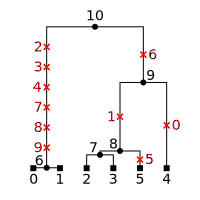

id,position,ancestral_state,metadata
0,0.30043643,0,
1,0.32220794,0,
2,0.36507027,0,
3,0.50940255,0,
4,0.51327137,0,
5,0.51400861,0,
6,0.54796110,0,
7,0.75929404,0,
8,0.80591800,0,
9,0.92324208,0,


In [13]:
from IPython.display import display
ts = tskit.load("data/afs.trees")
tree = ts.first()
display(tree.draw_svg())
ts.tables.sites

Computing the allele frequency spectrum is then easy:

In [14]:
afs = ts.allele_frequency_spectrum(polarised=True, span_normalise=False)
print(afs)

[0. 2. 6. 1. 1. 0. 0.]


This tells us that we have two singletons, six doubletons and one 3-ton and
one 4-ton. Note that the first element of the returned AFS array does *not* correspond
to the singletons (see below for why). Because we have simulated these mutations,
we know the ancestral and derived states we have set ``polarised`` to True. We
can get the "folded" AFS by setting polarised to False. Because we want simple
counts here and not averaged values, we set ``span_normalise=False``: by
default, windowed statistics are divided by the sequence length, so they are
comparable between windows.

The returned value here is actually a 2D array, and this is because we can
also perform these computations in windows along the genome:

In [15]:
afs = ts.allele_frequency_spectrum(windows=[0, 0.5, 1], span_normalise=False, polarised=True)
print(afs)

[[0. 1. 1. 1. 0. 0. 0.]
 [0. 1. 5. 0. 1. 0. 0.]]


This time, we've asked for the number of sites at each frequency in two
equal windows. Now we can see that in the first half of the sequence we
have three sites (compare with the site table above): one singleton,
one doubleton and one tripleton.

### Joint spectra

We can also compute allele frequencies within multiple sets of samples,
the *joint allele frequency spectra*.

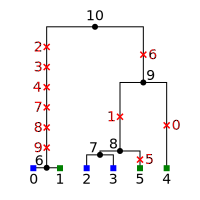

In [16]:
node_colours = {0: "blue", 2: "blue", 3: "blue", 1: "green", 4: "green", 5: "green"}
styles = [f".n{k} > .sym {{fill: {v}}}" for k, v in node_colours.items()]
tree.draw_svg(style = "".join(styles))

Here we've marked the samples as either blue or green (we can imagine
these belonging to different populations, for example). We can then compute
the joint AFS based on these two sets:

In [17]:
afs = ts.allele_frequency_spectrum([[0, 2, 3], [1, 4, 5]], polarised=True)
print(afs)

[[0. 2. 0. 0.]
 [0. 6. 0. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]]


Now, each window in our AFS is a 2D numpy array, where each dimension
corresponds to frequencies within the different sets. So, we see for example
that there are six sites that are singletons in both sets, 1 site
that is a doubleton in both sets, and 2 sites that singletons in $[1, 4, 5]$
and not present in the other sample set.

### Branch length spectra

Up to now we've used the {meth}`~TreeSequence.allele_frequency_spectrum` method
to summarise the number of sites that occur at different frequencies. We can also
use this approach to compute the total branch lengths subtending a given
number of samples by setting ``mode="branch"``:

In [18]:
afs = ts.allele_frequency_spectrum(mode="branch", polarised=True, span_normalise=False)
print(afs)

[0.         4.86089166 5.39638988 2.55239269 2.07444286 0.
 0.        ]


Thus, the total branch length over example one sample is 4.86, over two is
5.39, and so on.


(sec_tutorial_afs_zeroth_entry)=

### Zeroth and final entries in the AFS

The zeroth element of the AFS is significant when we are working with
sample sets that are a subset of all samples in the tree sequence.
For example, in the following we compute the AFS within the sample set
[0, 1, 2]:

In [19]:
afs = ts.allele_frequency_spectrum([[0, 1, 2]], mode="branch", polarised=True)
print(afs)

[4.33184862 5.30022646 5.252042   0.        ]


Thus, the total branch length over 0, 1 and 2 is 5.3, and over pairs from this set
is 5.25. What does the zeroth value of 4.33 signify? This is the total branch length
over all samples that are **not** in this sample set. By including this value, we
maintain the property that for each tree, the sum of the AFS for any sample set
is always equal to the total branch length. For example, here we compute:

In [20]:
print("sum afs          = ", np.sum(afs))
print("total branch len = ", tree.total_branch_length)

sum afs          =  14.884117086717392
total branch len =  14.884117086717396


The final entry of the AFS is similar: it counts alleles (for mode="site") or
branches (for mode="branch") that are ancestral to all of the given sample set,
but are still polymorphic in the entire set of samples of the tree sequence.
Note, however, that alleles fixed among all the samples, e.g., ones above
the root of the tree, will not be included.